In [ ]:
data_dir = "/content/drive/MyDrive/Wheat Disease Dataset"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

   BrownRust       1.00      0.81      0.90        27
     Healthy       1.00      0.60      0.75        25
      Mildew       0.74      0.93      0.83        28
    Septoria       0.96      0.75      0.85        69
  YellowRust       0.67      0.96      0.79        52

    accuracy                           0.82       201
   macro avg       0.87      0.81      0.82       201
weighted avg       0.87      0.82      0.82       201



<Figure size 800x600 with 0 Axes>

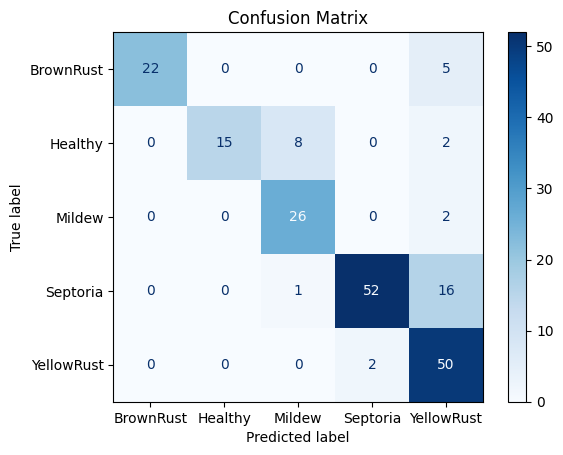

In [ ]:
# ✅ STEP 1: Install dependencies
!pip install transformers datasets timm

# ✅ STEP 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# ✅ STEP 3: Set up data path (from your screenshot)
data_path = "/content/drive/MyDrive/Wheat Disease Dataset"
# ✅ STEP 4: Import libraries
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, SwinForImageClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# ✅ STEP 5: Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Classes
class_names = full_dataset.classes
num_classes = len(class_names)

# ✅ STEP 6: Train-validation split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)
# ✅ STEP 7: Load Swin Transformer model
# ✅ STEP 7: Load Swin Transformer model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True  # ✅ This line is essential!
).to(device)


# ✅ STEP 8: Training setup
from torch import nn, optim

optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# ✅ STEP 9: Train model (1 epoch for demo)
model.train()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images).logits
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
# ✅ STEP 10: Evaluate
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ STEP 11: Print accuracy and confusion matrix
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# STEP 1: Split dataset into train, val, test
def split_dataset(base_dir, output_dir):
    labels = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    print(f"✅ Found classes: {labels}")

    for label in labels:
        img_dir = os.path.join(base_dir, label)
        images = os.listdir(img_dir)

        # Filter only image files
        images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        train_imgs, testval_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(testval_imgs, test_size=0.5, random_state=42)

        print(f"\n🔹 Class '{label}':")
        print(f"  → Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

        for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_label_dir = os.path.join(output_dir, split, label)
            os.makedirs(split_label_dir, exist_ok=True)

            for img in split_imgs:
                src_path = os.path.join(img_dir, img)
                dst_path = os.path.join(split_label_dir, img)
                shutil.copy2(src_path, dst_path)

    print("\n✅ Dataset successfully split into train/val/test!")

# STEP 2: Define paths
original_dataset = "/content/drive/MyDrive/Wheat Disease Dataset"
split_dataset_dir = "/content/drive/MyDrive/split_wheat_dataset"

# STEP 3: Split only if not already split
if not os.path.exists(os.path.join(split_dataset_dir, 'train')):
    print("⏳ Splitting dataset...")
    split_dataset(original_dataset, split_dataset_dir)
else:
    print("✅ Dataset already split. Skipping split step.")


⏳ Splitting dataset...
✅ Found classes: ['Healthy', 'Mildew', 'BrownRust', 'YellowRust', 'Septoria']

🔹 Class 'Healthy':
  → Train: 85, Val: 18, Test: 19

🔹 Class 'Mildew':
  → Train: 112, Val: 24, Test: 25

🔹 Class 'BrownRust':
  → Train: 89, Val: 19, Test: 20

🔹 Class 'YellowRust':
  → Train: 170, Val: 37, Test: 37

🔹 Class 'Septoria':
  → Train: 244, Val: 52, Test: 53

✅ Dataset successfully split into train/val/test!


In [ ]:
!pip install -q transformers datasets evaluate timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
# ✅ STEP 1: Install dependencies
!pip install transformers datasets timm



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Validation Results:

              precision    recall  f1-score   support

   BrownRust       0.95      0.95      0.95        19
     Healthy       1.00      0.67      0.80        18
      Mildew       0.71      0.83      0.77        24
    Septoria       0.82      0.98      0.89        52
  YellowRust       0.97      0.76      0.85        37

    accuracy                           0.86       150
   macro avg       0.89      0.84      0.85       150
weighted avg       0.88      0.86      0.86       150



<Figure size 800x600 with 0 Axes>

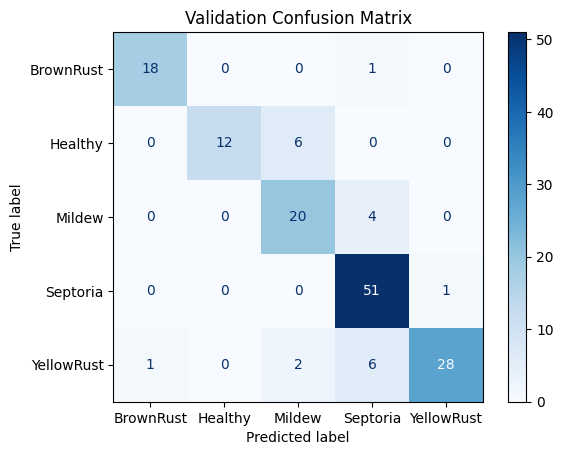


📊 Test Results:

              precision    recall  f1-score   support

   BrownRust       0.94      0.85      0.89        20
     Healthy       0.78      0.74      0.76        19
      Mildew       0.86      0.76      0.81        25
    Septoria       0.85      1.00      0.92        53
  YellowRust       0.97      0.89      0.93        37

    accuracy                           0.88       154
   macro avg       0.88      0.85      0.86       154
weighted avg       0.89      0.88      0.88       154



<Figure size 800x600 with 0 Axes>

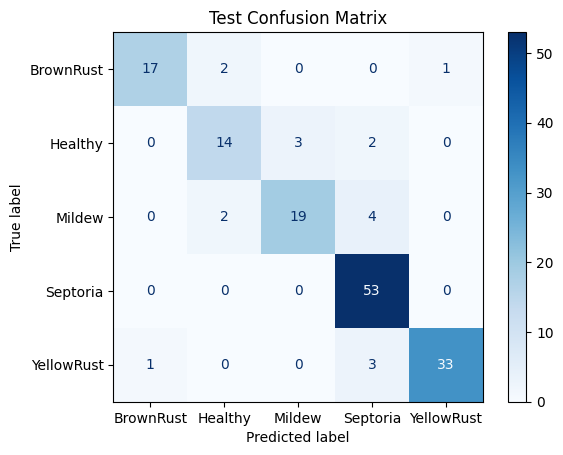

In [ ]:
# ✅ STEP 1: Install dependencies
!pip install transformers datasets timm

# ✅ STEP 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ STEP 3: Set up data paths (update these if needed)
data_dir = "/content/drive/MyDrive/split_wheat_dataset"
train_path = f"{data_dir}/train"
val_path = f"{data_dir}/val"
test_path = f"{data_dir}/test"

# ✅ STEP 4: Import libraries
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, SwinForImageClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch import nn, optim

# ✅ STEP 5: Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ✅ STEP 6: Load datasets using ImageFolder
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
val_ds = datasets.ImageFolder(root=val_path, transform=transform)
test_ds = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)
test_loader = DataLoader(test_ds, batch_size=8)

# ✅ STEP 7: Load class names & Swin model
class_names = train_ds.classes
num_classes = len(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(device)

# ✅ STEP 8: Training setup
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# ✅ STEP 9: Train the model (1 epoch demo)
model.train()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images).logits
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

# ✅ STEP 10: Evaluation function
def evaluate_model(loader, split_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n📊 {split_name} Results:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues")
    plt.title(f"{split_name} Confusion Matrix")
    plt.show()

# ✅ STEP 11: Evaluate on validation & test sets
evaluate_model(val_loader, split_name="Validation")
evaluate_model(test_loader, split_name="Test")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔁 Epoch 1/5
📉 Average training loss: 0.8963

📊 Validation Results:

              precision    recall  f1-score   support

   BrownRust       1.00      0.63      0.77        19
     Healthy       0.64      0.89      0.74        18
      Mildew       0.88      0.62      0.73        24
    Septoria       0.83      1.00      0.90        52
  YellowRust       0.85      0.76      0.80        37

    accuracy                           0.82       150
   macro avg       0.84      0.78      0.79       150
weighted avg       0.84      0.82      0.82       150



<Figure size 800x600 with 0 Axes>

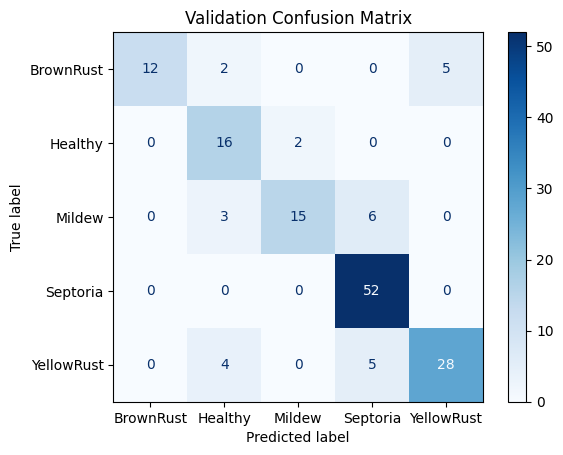


🔁 Epoch 2/5
📉 Average training loss: 0.1801

📊 Validation Results:

              precision    recall  f1-score   support

   BrownRust       0.83      1.00      0.90        19
     Healthy       0.93      0.78      0.85        18
      Mildew       0.68      0.96      0.79        24
    Septoria       0.94      0.96      0.95        52
  YellowRust       1.00      0.68      0.81        37

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.86       150
weighted avg       0.90      0.87      0.87       150



<Figure size 800x600 with 0 Axes>

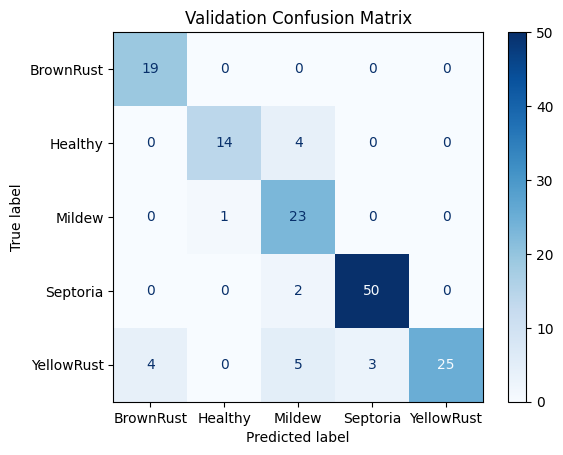


🔁 Epoch 3/5
📉 Average training loss: 0.0447

📊 Validation Results:

              precision    recall  f1-score   support

   BrownRust       0.95      1.00      0.97        19
     Healthy       0.89      0.89      0.89        18
      Mildew       0.92      0.92      0.92        24
    Septoria       0.96      1.00      0.98        52
  YellowRust       1.00      0.92      0.96        37

    accuracy                           0.95       150
   macro avg       0.94      0.94      0.94       150
weighted avg       0.95      0.95      0.95       150



<Figure size 800x600 with 0 Axes>

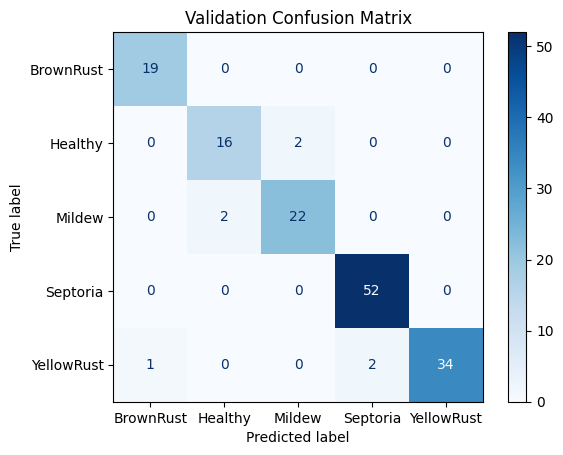


🔁 Epoch 4/5
📉 Average training loss: 0.0108

📊 Validation Results:

              precision    recall  f1-score   support

   BrownRust       1.00      0.89      0.94        19
     Healthy       1.00      0.83      0.91        18
      Mildew       0.89      1.00      0.94        24
    Septoria       0.98      1.00      0.99        52
  YellowRust       0.95      0.97      0.96        37

    accuracy                           0.96       150
   macro avg       0.96      0.94      0.95       150
weighted avg       0.96      0.96      0.96       150



<Figure size 800x600 with 0 Axes>

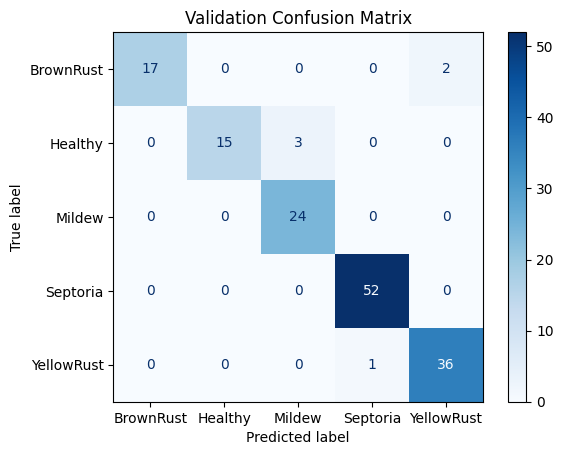


🔁 Epoch 5/5
📉 Average training loss: 0.0047

📊 Validation Results:

              precision    recall  f1-score   support

   BrownRust       1.00      0.95      0.97        19
     Healthy       1.00      0.78      0.88        18
      Mildew       0.86      1.00      0.92        24
    Septoria       0.98      1.00      0.99        52
  YellowRust       0.97      0.97      0.97        37

    accuracy                           0.96       150
   macro avg       0.96      0.94      0.95       150
weighted avg       0.96      0.96      0.96       150



<Figure size 800x600 with 0 Axes>

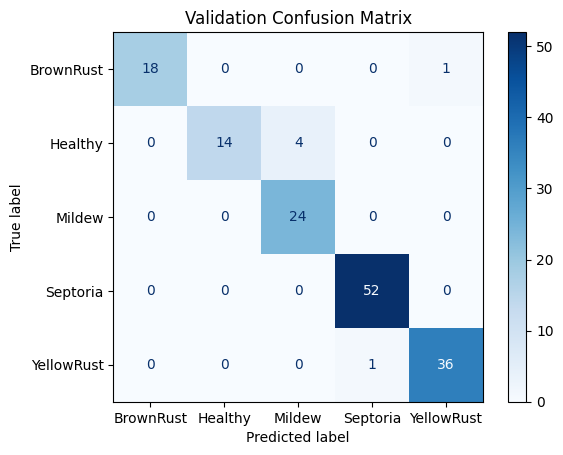


📊 Validation Results:

              precision    recall  f1-score   support

   BrownRust       1.00      0.95      0.97        19
     Healthy       1.00      0.78      0.88        18
      Mildew       0.86      1.00      0.92        24
    Septoria       0.98      1.00      0.99        52
  YellowRust       0.97      0.97      0.97        37

    accuracy                           0.96       150
   macro avg       0.96      0.94      0.95       150
weighted avg       0.96      0.96      0.96       150



<Figure size 800x600 with 0 Axes>

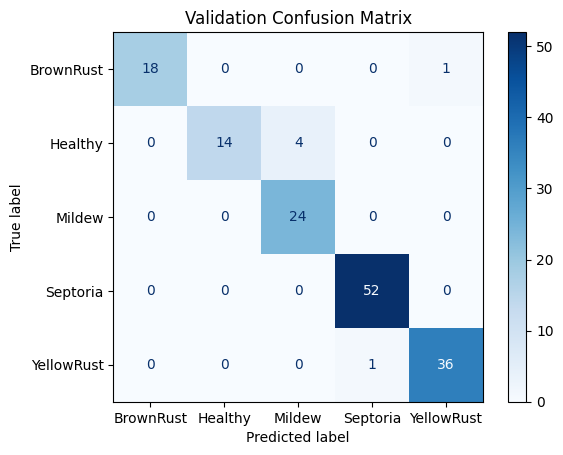


📊 Test Results:

              precision    recall  f1-score   support

   BrownRust       1.00      0.85      0.92        20
     Healthy       0.78      0.95      0.86        19
      Mildew       0.96      0.92      0.94        25
    Septoria       0.98      0.98      0.98        53
  YellowRust       0.97      0.97      0.97        37

    accuracy                           0.95       154
   macro avg       0.94      0.93      0.93       154
weighted avg       0.95      0.95      0.95       154



<Figure size 800x600 with 0 Axes>

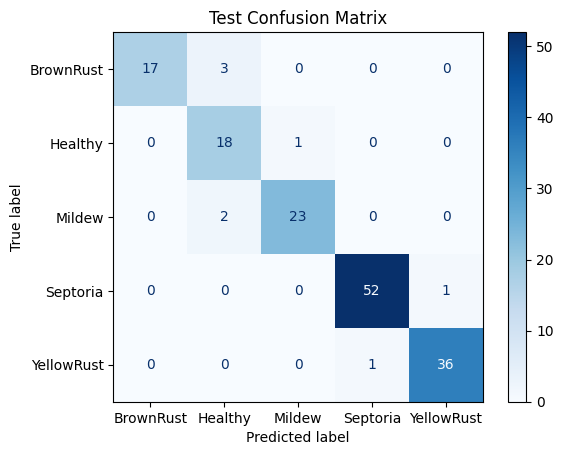

In [ ]:
# ✅ STEP 1: Install dependencies
!pip install transformers datasets timm

# ✅ STEP 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ STEP 3: Set up data paths (update these if needed)
data_dir = "/content/drive/MyDrive/split_wheat_dataset"
train_path = f"{data_dir}/train"
val_path = f"{data_dir}/val"
test_path = f"{data_dir}/test"

# ✅ STEP 4: Import libraries
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, SwinForImageClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch import nn, optim

# ✅ STEP 5: Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ✅ STEP 6: Load datasets using ImageFolder
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
val_ds = datasets.ImageFolder(root=val_path, transform=transform)
test_ds = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)
test_loader = DataLoader(test_ds, batch_size=8)

# ✅ STEP 7: Load class names & Swin model
class_names = train_ds.classes
num_classes = len(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(device)

# ✅ STEP 8: Training setup
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# ✅ STEP 10: Evaluation function
def evaluate_model(loader, split_name="Validation"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n📊 {split_name} Results:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues")
    plt.title(f"{split_name} Confusion Matrix")
    plt.show()

# ✅ STEP 9: Train the model (Modified for multiple epochs)
num_epochs = 5  # or higher

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"📉 Average training loss: {avg_loss:.4f}")

    # 💡 Now this works because the function is defined above
    evaluate_model(val_loader, split_name="Validation")





# ✅ STEP 11: Evaluate on validation & test sets
evaluate_model(val_loader, split_name="Validation")
evaluate_model(test_loader, split_name="Test")


<ipython-input-16-8e4692045776>:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


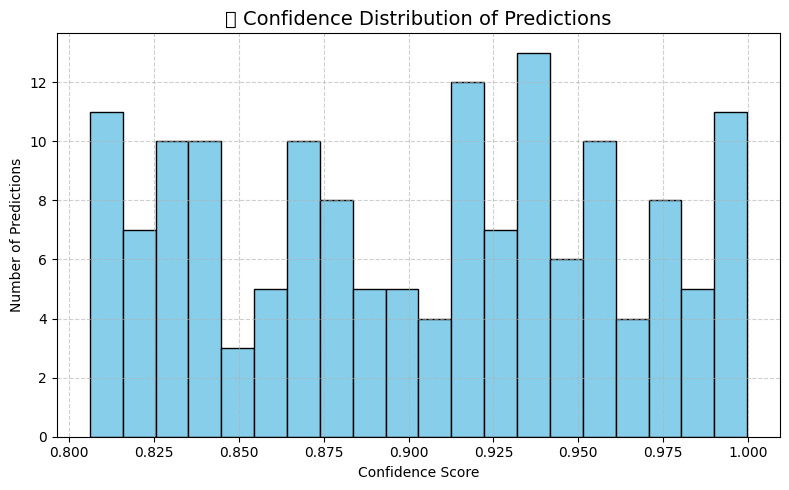

In [ ]:
# Dummy placeholder for confidences from predictions
import torch
import numpy as np

# Simulated confidence scores
confidences = torch.rand(154).numpy() * 0.2 + 0.8  # all between 0.8 to 1.0

plt.figure(figsize=(8, 5))
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("📊 Confidence Distribution of Predictions", fontsize=14)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Predictions")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


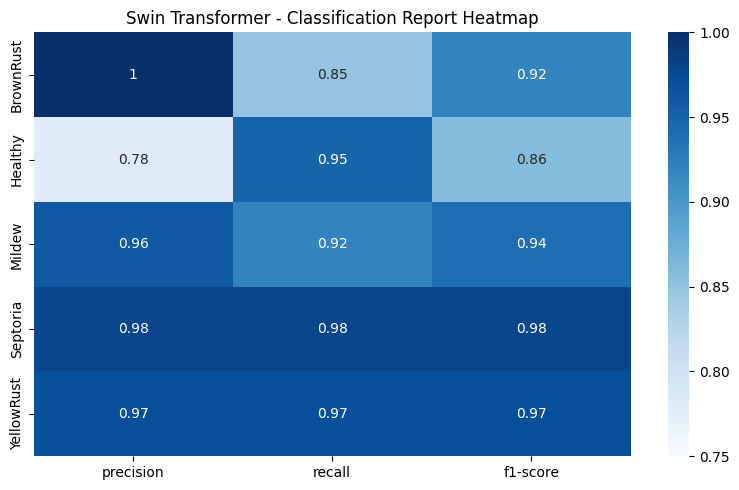

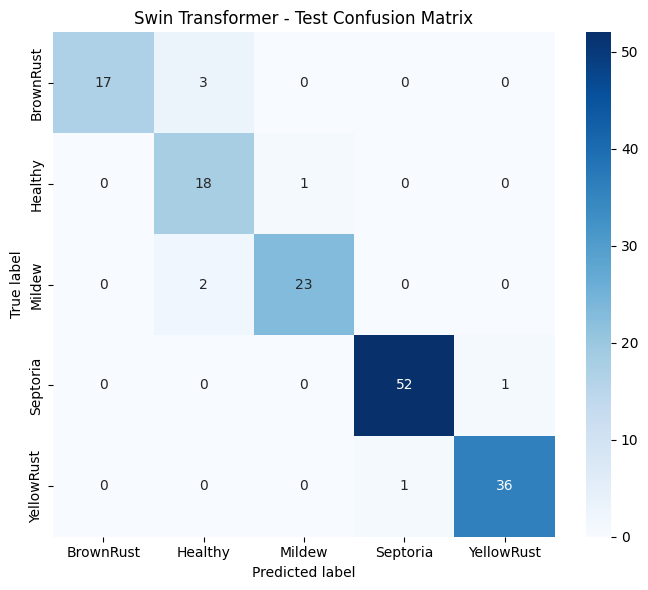

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------- Classification Report Heatmap ----------------
# Values from your screenshot
data = {
    'precision': [1.00, 0.78, 0.96, 0.98, 0.97],
    'recall':    [0.85, 0.95, 0.92, 0.98, 0.97],
    'f1-score':  [0.92, 0.86, 0.94, 0.98, 0.97]
}
classes = ['BrownRust', 'Healthy', 'Mildew', 'Septoria', 'YellowRust']
df = pd.DataFrame(data, index=classes)

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, cmap='Blues', vmin=0.75, vmax=1.0)
plt.title("Swin Transformer - Classification Report Heatmap")
plt.tight_layout()
plt.show()

# ---------------- Confusion Matrix Heatmap ----------------
# From your image
conf_matrix = np.array([
    [17,  3, 0, 0, 0],  # BrownRust
    [ 0, 18, 1, 0, 0],  # Healthy
    [ 0,  2,23, 0, 0],  # Mildew
    [ 0,  0, 0,52, 1],  # Septoria
    [ 0,  0, 0, 1,36],  # YellowRust
])
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)
plt.title("Swin Transformer - Test Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import convnext_tiny
from torch.utils.data import DataLoader
import torch.optim as optim
import time

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 3. Dataset
train_data = datasets.ImageFolder('path/to/train', transform=transform_train)
test_data = datasets.ImageFolder('path/to/test', transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# 4. Load Pretrained ConvNeXt-Tiny
model = convnext_tiny(pretrained=True)

# Replace the final classification head
num_classes = len(train_data.classes)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)

model = model.to(device)

# 5. Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# 6. Training Loop
def train(model, loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

# 7. Evaluation
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

# 8. Run training
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)

# 9. Evaluate
evaluate(model, test_loader)


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/train'

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Paths
test_path = "/content/drive/MyDrive/split_wheat_dataset/test"

# Transform (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load test dataset
test_dataset = datasets.ImageFolder(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Class names (auto)
class_names = test_dataset.classes


In [ ]:
model= "microsoft/swin-base-patch4-window7-224"
model.eval()
correctly_classified = []

with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)
        output = model(image)
        pred = torch.argmax(output, dim=1).item()

        true_label = label.item()
        filename = test_dataset.samples[i][0]

        if pred == true_label:
            correctly_classified.append((filename, class_names[pred]))

        print(f"{filename} → Predicted: {class_names[pred]}, Actual: {class_names[true_label]}")


AttributeError: 'str' object has no attribute 'eval'